# Mental Health HPSA data analysis

Introduction to Data Analysis, Reporting 2  
Group 7: Julia Ingram, Chuqin Jiang, Richard Abbey  

This workbook examines a dataset of federally designated mental health healthcare provider shortage areas (HPSAs), downloaded on 10/18/21 from the Health Resources & Service Administration's website (https://data.hrsa.gov/data/download). An explanation of the shortage areas and how they are designated can be found in the federal register, here: https://www.ecfr.gov/current/title-42/chapter-I/subchapter-A/part-5

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [5]:
#Reading in the HPSA file
HPSAs = pd.read_csv('BCD_HPSA_FCT_DET_MH.csv')

## Data cleaning

In [ ]:
HPSAs.dtypes #Understanding the datatypes

We'll want the dates as datetime64 so we can work with them

In [6]:
HPSAs['HPSA Designation Date'] = HPSAs['HPSA Designation Date'].astype(np.datetime64)
HPSAs['Withdrawn Date'] = HPSAs['Withdrawn Date'].astype(np.datetime64)

We'll also want the respective 'Year' column for designation date as an integer rather than a string

In [7]:
HPSAs['HPSA Designation Year'] = HPSAs['HPSA Designation Year'].astype(int)

### Separating different HPSA Types
Subsetting the data by type: geographic, population and facility HPSA

In [8]:
facilityTypes = ['Correctional Facility', 'Federally Qualified Health Center', 'Federally Qualified Health Center Look A Like',
                 'Indian Health Service, Tribal Health, and Urban Indian Health Organizations', 'Rural Health Clinic',
                 'Other Facility', 'State Mental Hospital']
geoTypes = ['Geographic HPSA', 'High Needs Geographic HPSA']

In [9]:
facilityHPSAs = HPSAs[HPSAs['Designation Type'].isin(facilityTypes)==True]
geoHPSAs = HPSAs[HPSAs['Designation Type'].isin(geoTypes)==True]
popHPSAs = HPSAs[HPSAs['Designation Type']=='HPSA Population']

## Answering specific questions

### What is the total estimated underserved population at present?

Using both HPSA geographic and population designations, which don't geographically overlap, but excluding facilities, which do

In [10]:
HPSAsClean = HPSAs.drop_duplicates(subset='HPSA ID')
HPSAsClean = HPSAsClean[(HPSAsClean['Designation Type'].isin(geoTypes)==True) | (HPSAsClean['Designation Type']=='HPSA Population')]

In [11]:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]

In [12]:
populationFigs = []
for year in years:
    value = HPSAsClean[(HPSAsClean['HPSA Designation Year']<=year) 
                       & ((HPSAsClean['Withdrawn Date']>= np.datetime64(str(year)+'-12-31')) 
                          |HPSAsClean['Withdrawn Date'].isnull() == True)]['HPSA Designation Population'].sum()
    populationFigs.append(value)

In [13]:
populationFigs

[96923783.0,
 105031580.0,
 120675494.0,
 112816930.0,
 114907038.0,
 119746344.0,
 128691227.0]

A percent of the total population using "Population Figs" was calculated in Excel using population data from World Population Review, then copied into Datawrapper

### How many of the non-rural, low-income HPSAs were designated during the pandemic?

In [14]:
newLIPops = HPSAs[(HPSAs['Designation Type']=='HPSA Population')
                  & (HPSAs['HPSA Designation Date']>=np.datetime64('2020-03-01'))
                  & (HPSAs['HPSA Status']=='Designated')
                  & (HPSAs['HPSA Population Type'].str.contains('Low Income'))]

In [15]:
len(newLIPops)

1436

In [16]:
allLIPops = HPSAs[(HPSAs['Designation Type']=='HPSA Population')
                  & (HPSAs['HPSA Status']=='Designated')
                  & (HPSAs['HPSA Population Type'].str.contains('Low Income'))]

In [17]:
len(allLIPops)

2869

In [18]:
len(newLIPops)/len(allLIPops)

0.5005228302544441

### Household Pulse Survey Data

This section examines demand for mental health resources using the Census Bureau's Household Pulse survey. Demand for resources helps contextualize findings on the shortage of them. The Houshold Pulse Survey data can be found at https://www.census.gov/programs-surveys/household-pulse-survey/data.html. We used Health Tables 2a and 2b, on symptoms of depression and anxiety, respectively, and Table 4, on mental health activities in the past four weeks. 

In [23]:
def getNumber(filename, columns, row, location, skip): #column number(s) (0 indexed) as a list, row number minus 5
    pulseDF = pd.read_excel(filename, sheet_name=location, skiprows=skip)
    count = 0
    for column in columns:
        if pulseDF.iat[row, column] == '-':
            count+= 0
        else: 
            count+= pulseDF.iat[row, column]
    return count

In [25]:
def buildTable(filenamesList, columns, row, location, skip):
    table = []
    for f in filenamesList:
        table.append(getNumber(f, columns, row, location, skip))
    return table

In [2]:
startWeek = 22
endWeek = 39
filenames_anxiety = ['health2a_week{}.xlsx'.format(i) for i in range(startWeek, endWeek + 1)]
filenames_depression = ['health2b_week{}.xlsx'.format(i) for i in range(startWeek, endWeek + 1)]
filenames_care = ['health4_week{}.xlsx'.format(i) for i in range(startWeek, endWeek + 1)]

In [42]:
xlabels = ['{}'.format(i) for i in range(startWeek, endWeek + 1)]

In [19]:
#Anxiety table
buildTable(filenames_anxiety, [7,8,9], 1, 'US', 6)

[109522837.0,
 114195211.0,
 108967581.0,
 107827623.0,
 102520745.0,
 97241988.0,
 88194285.0,
 87588148.0,
 87694341.0,
 85760436.0,
 86796153.0,
 84133947.0,
 102968637.0,
 102331095.0,
 107247897.0,
 105685952.0,
 103866819.0,
 102607890.0]

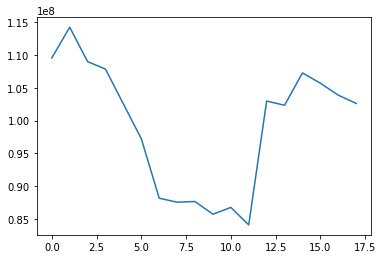

In [27]:
plt.plot(buildTable(filenames_anxiety, [7,8,9], 1, 'US', 6),label='Anxiety')

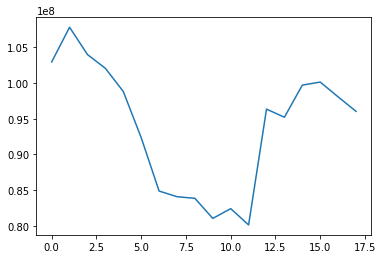

In [37]:
plt.plot(buildTable(filenames_depression, [7,8,9], 1, 'US', 6),label='Depression')

In [36]:
(buildTable(filenames_depression, [7,8,9], 1, 'US', 6))

[102961129.0,
 107832064.0,
 103998712.0,
 102070011.0,
 98823244.0,
 92350923.0,
 84859301.0,
 84067864.0,
 83837557.0,
 81020344.0,
 82392254.0,
 80108963.0,
 96348274.0,
 95211365.0,
 99717194.0,
 100142940.0,
 98065426.0,
 96035429.0]

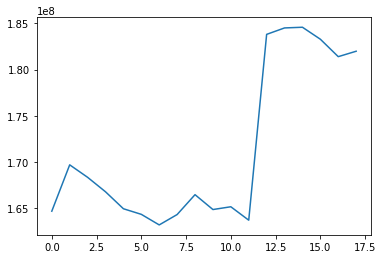

In [33]:
plt.plot(buildTable(filenames_care, [6], 1, 'US', 5),label='Needed counseling but did not get it')

In [32]:
(buildTable(filenames_care, [6], 1, 'US', 5))

[164690139.0,
 169699637.0,
 168351930.0,
 166787484.0,
 164954665.0,
 164349566.0,
 163206319.0,
 164326982.0,
 166475872.0,
 164868625.0,
 165168675.0,
 163717671.0,
 183803880.0,
 184499640.0,
 184574293.0,
 183279934.0,
 181394767.0,
 181981354.0]

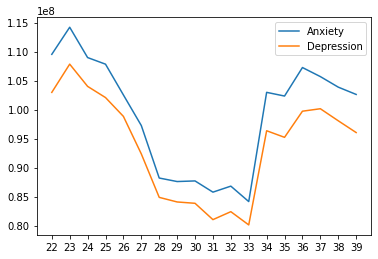

In [43]:
plt.plot(xlabels, buildTable(filenames_anxiety, [7,8,9], 1, 'US', 6),label='Anxiety')
plt.plot(xlabels, buildTable(filenames_depression, [7,8,9], 1, 'US', 6),label='Depression')
plt.legend()
plt.show()

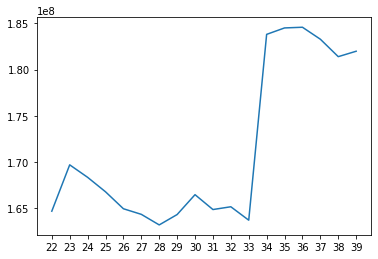

In [44]:
plt.plot(xlabels, buildTable(filenames_care, [6], 1, 'US', 5),label='Needed counseling but did not get it')